In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler as SS
matplotlib.rcParams['figure.figsize'] = [10.0, 10.0]
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.color'] = 'r'
matplotlib.rcParams['font.size'] = 20.0
matplotlib.rcParams['figure.dpi'] = 100

In [2]:
import keras
from keras.layers import Dense, Dropout, Input,Lambda, concatenate, add, AlphaDropout,GaussianDropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.activations import selu, relu
from keras.losses import mae, mse
from keras.optimizers import Nadam
from keras.models import Model
from keras.constraints import maxnorm
from IPython.display import clear_output

Using TensorFlow backend.


In [3]:
X_df = pd.read_csv('./data/final_10.csv',index_col=0)
Y_df = pd.read_csv('./data/final_whole.csv',index_col=0)

In [4]:
X_df = X_df.sort_index()
Y_df = Y_df.sort_index()

In [5]:
X = X_df.values
Y = Y_df.values

In [6]:
X.shape

(6348, 66)

In [7]:
Y.shape

(6348, 66)

In [153]:
X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)
X_train, X_v, y_train, y_v = tts(X_train, y_train, test_size=0.3, random_state=42)

#extracting id's of depressed and normal entries to use it later in the test set analysis.

scaler = SS()
X_train = scaler.fit_transform(X_train)
X_v = scaler.transform(X_v)
X_test = scaler.transform(X_test)

scaler1 = SS()
y_train = scaler1.fit_transform(y_train)
y_v = scaler1.transform(y_v)
y_test = scaler1.transform(y_test)

### Building a simple DL model, allowing to predict all the features at the same time

In [154]:
def init_model(inp_shape):
    dout = 0.30
    a = Input(shape=(inp_shape,))
    b = Dropout(dout/2.0)(a)
    #b = BatchNormalization()(a)
    b = Dense(64,activation='selu')(b)
    b = Dropout(dout)(b)
    #b = BatchNormalization()(b)
    #b = Dense(128,activation='relu')(b)
    #b = BatchNormalization()(b)
    #b = Dropout(dout)(b)
    #b = Dense(256,activation='selu')(b)
    #b = Dropout(dout)(b)
    #b = Dense(128,activation='selu')(b)

    output = Dense(inp_shape,activation='linear')(b)

    model = Model(inputs=a, outputs=output)
    opt = Nadam(1e-4)
    model.compile(optimizer = opt, loss=mse,)
    
    return model

# the class is retrieved from: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [155]:
model = init_model(inp_shape=X_train.shape[1])

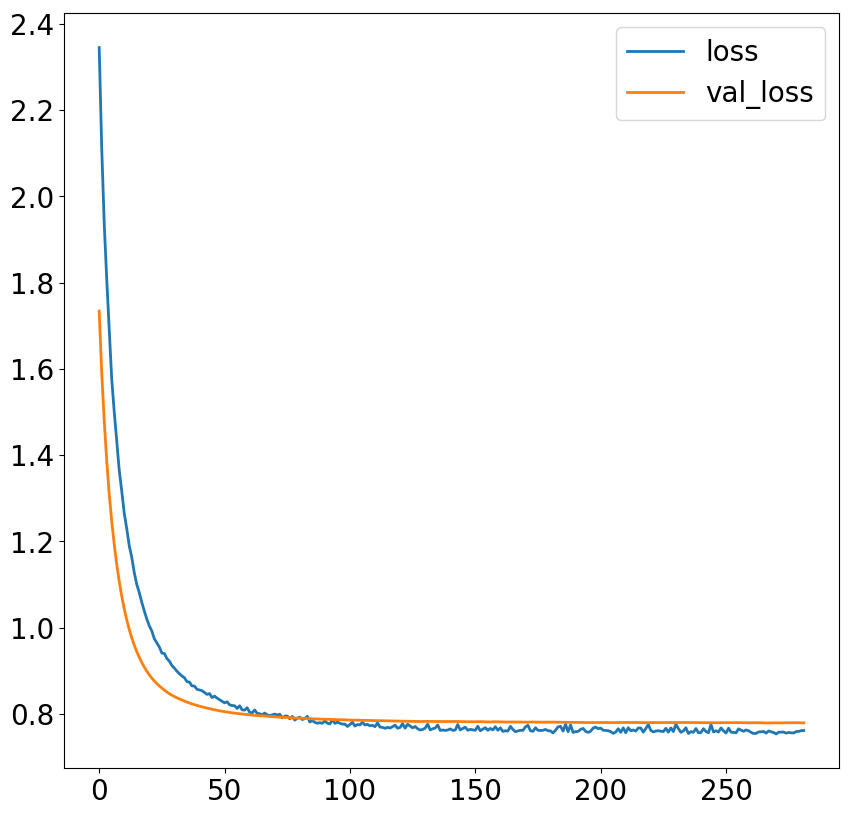

In [156]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=32,validation_data=(X_v,y_v),callbacks=[EarlyStopping(patience=15),plot_losses],shuffle=True,verbose=0)

In [157]:
y_pred = model.predict(X_test)

In [158]:
from sklearn.metrics import normalized_mutual_info_score as mi_sklearn

In [159]:
mis_sklearn = []
for i in range(y_pred.shape[1]):
    print(X_df.columns.tolist()[i], mi_sklearn(y_pred[:,i],y_test[:,i]))
    mis_sklearn.append(mi_sklearn(y_pred[:,i],y_test[:,i]))

favorite_count 0.860601957391
days 0.659197316779
posts_number_all 0.932716528128
text_length 0.602692440554
reply_ratio 0.945169280524
vad_0 0.924580435833
vad_1 0.91758294867
vad_2 0.916665484347
time_0 0.752473883502
time_1 0.739705334186
time_2 0.744301995045
time_3 0.735694786457
time_4 0.737550877791
time_5 0.733467136318
time_6 0.733062552876
time_7 0.743178966184
time_8 0.73795413728
time_9 0.690113040323
time_10 0.677082039686
time_11 0.659722111656
time_12 0.66557982039
time_13 0.681911619188
time_14 0.697600429848
time_15 0.715973407049
time_16 0.72643633713
time_17 0.738976255336
time_18 0.74012236626
time_19 0.734583668462
time_20 0.730157492489
time_21 0.732128680101
time_22 0.719491246148
time_23 0.701543404699
depression_symptoms_count_0 0.792194044824
depression_symptoms_count_1 0.612458785211
depression_symptoms_count_2 0.477394337272
depression_symptoms_count_3 0.32605028166
depression_symptoms_count_4 0.660973920399
depression_symptoms_count_5 0.594026857917
depress

In [198]:
np.average(mis_sklearn[:-25])

0.71063671321838406

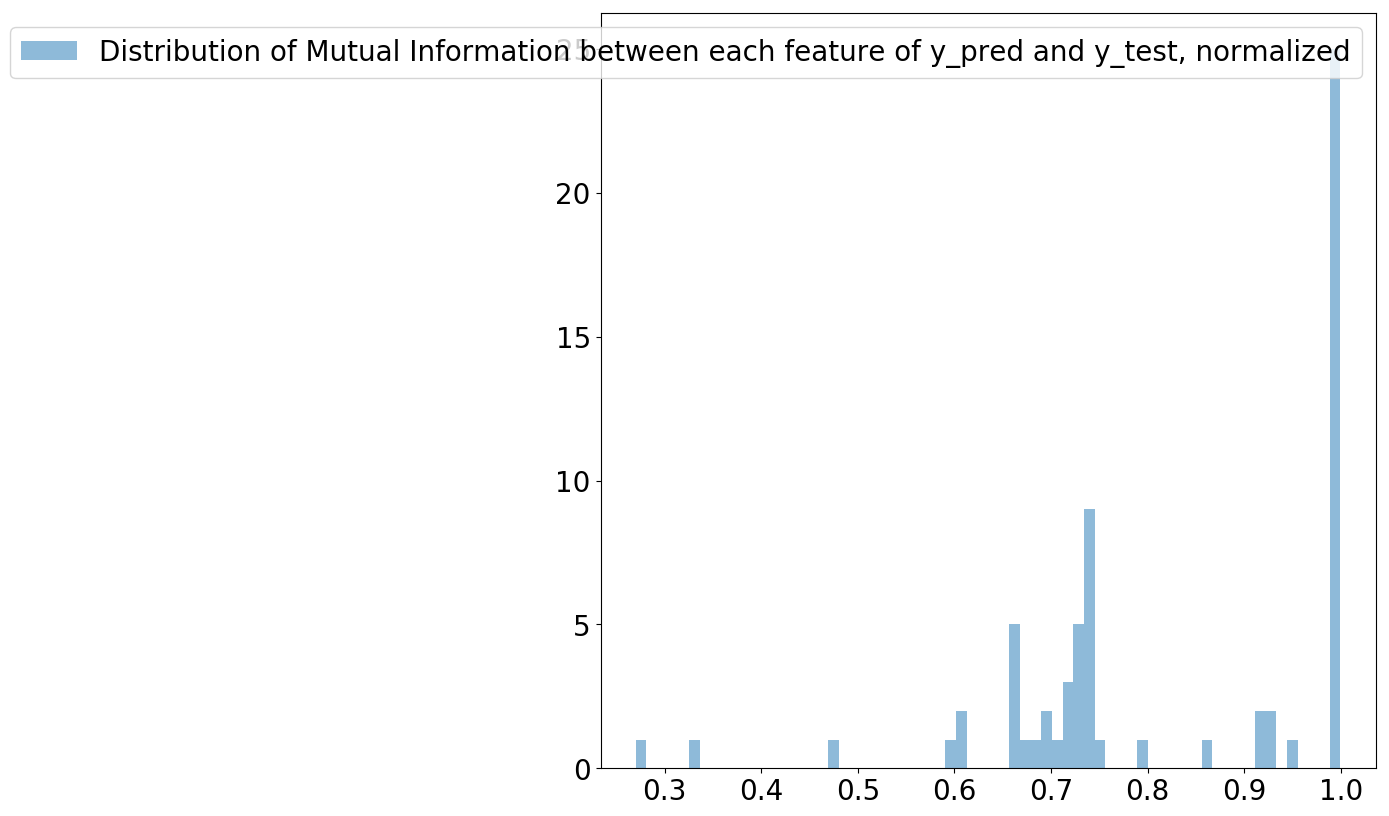

In [160]:
plt.hist(np.array(mis_sklearn),bins = y_test.shape[1],label = 'Distribution of Mutual Information between each feature of y_pred and y_test, normalized',alpha=0.5)
plt.legend()
plt.show()

### The issue is that: how could it predict LDA so good?? Is there something wrong with LDA?

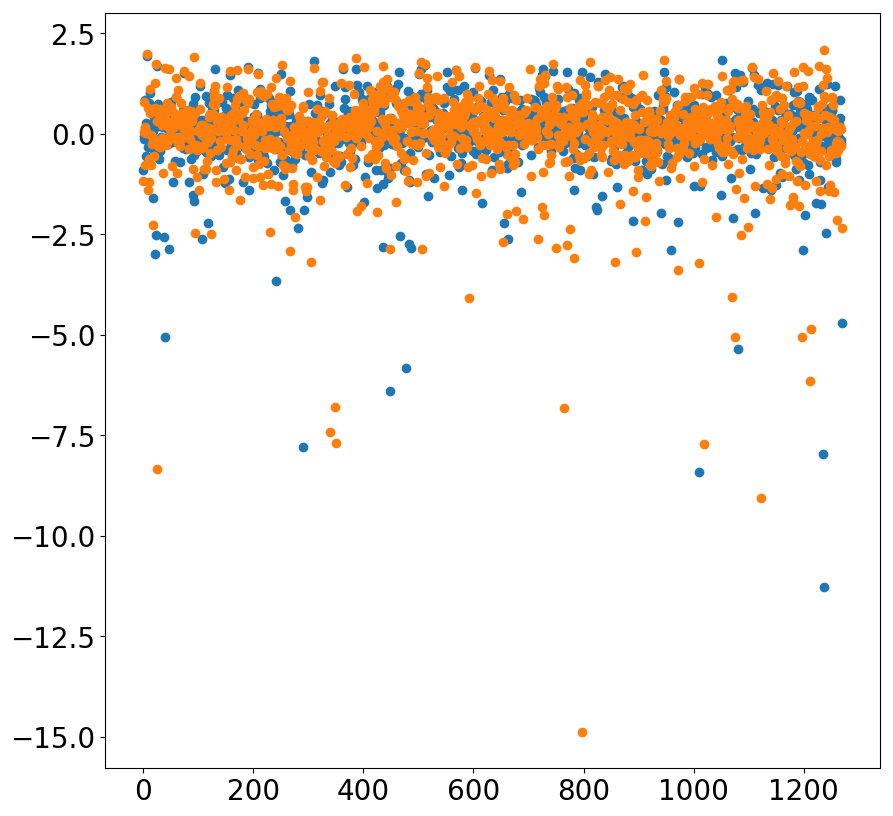

In [161]:
# plotting differences for two components of LDA
plt.scatter(x=np.arange(len(y_pred)),y=y_pred[:,-2]-y_test[:,-2])
plt.scatter(x=np.arange(len(y_pred)),y=y_pred[:,-1]-y_test[:,-1])

In [162]:
from sklearn.svm import SVR

In [163]:
svm = SVR()
svm.fit(X_train,y_train[:,[-1]])

C:\Users\B7066789\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [164]:
y_pred_1d = svm.predict(X_test)

In [165]:
mi_sklearn(y_pred_1d,y_test[:,-1])

0.99940750823499103

## What is a relation between amount of text available and prediction error?

In [169]:
X_test_raw = scaler.inverse_transform(X_test)

In [219]:
X_df.columns

Index(['favorite_count', 'days', 'posts_number_all', 'text_length',
       'reply_ratio', 'vad_0', 'vad_1', 'vad_2', 'time_0', 'time_1', 'time_2',
       'time_3', 'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9',
       'time_10', 'time_11', 'time_12', 'time_13', 'time_14', 'time_15',
       'time_16', 'time_17', 'time_18', 'time_19', 'time_20', 'time_21',
       'time_22', 'time_23', 'depression_symptoms_count_0',
       'depression_symptoms_count_1', 'depression_symptoms_count_2',
       'depression_symptoms_count_3', 'depression_symptoms_count_4',
       'depression_symptoms_count_5', 'depression_symptoms_count_6',
       'depression_symptoms_count_7', 'depression_symptoms_count_8', 'lda_0',
       'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8',
       'lda_9', 'lda_10', 'lda_11', 'lda_12', 'lda_13', 'lda_14', 'lda_15',
       'lda_16', 'lda_17', 'lda_18', 'lda_19', 'lda_20', 'lda_21', 'lda_22',
       'lda_23', 'lda_24'],
      dtype='object')

In [321]:
import scipy

def f(x,a,b,c):
    return a+(1/x)**b

x_ft = X_test_raw[:,2]*X_test_raw[:,3]
y_ft = abs(np.average(y_test-y_pred,axis=1))
           
fit_params = scipy.optimize.curve_fit(f=f,xdata=x_ft,ydata=y_ft)[0]
x_ft_vals = np.arange(10000)
y_ft_vals = f(x_ft_vals,fit_params[0],fit_params[1],fit_params[2])

C:\Users\B7066789\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\B7066789\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [322]:
fit_params

array([ 0.0552026 ,  0.96009899,  1.        ])

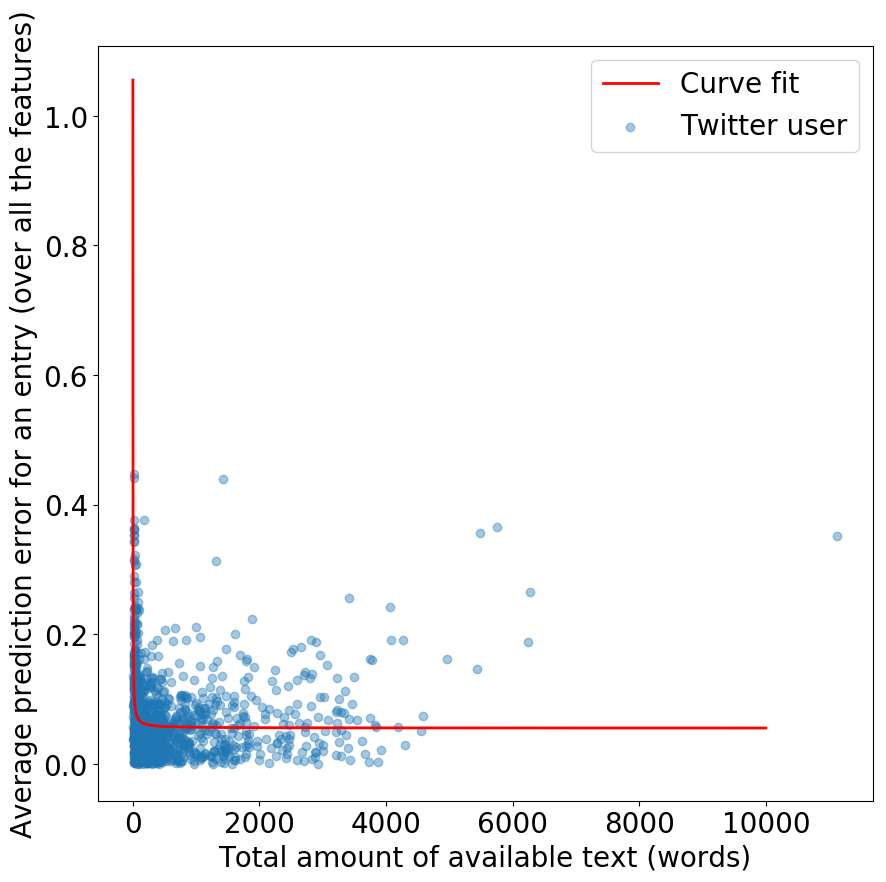

In [323]:
#color - amount of text 
plt.scatter(x=X_test_raw[:,2]*X_test_raw[:,3],y=abs(np.average(y_test-y_pred,axis=1)),label='Twitter user',alpha=0.4) # there is the expected relation for text_length (exponential decrease of an error when increasing an average tweet length), which is an average (?) number of words in one post. 
plt.plot(x_ft_vals,y_ft_vals,label = 'Curve fit',color='red')
plt.xlabel('Total amount of available text (words)')
plt.ylabel('Average prediction error for an entry (over all the features)')
plt.legend()
#plt.colorbar()
plt.show()